#**Toronto ETA Prediction**

# **Import Library**

In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 15.8 MB/s 
     |████████████████████████████████| 15.4 MB 30 kB/s 


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import shapely
import matplotlib.pyplot as plot
%matplotlib inline
from matplotlib.pyplot import figure


# **Reading Inputs**

Here, we input Toronto Travel time data for January 2020 to March 2020. We consider the weekly aggregate for modeling. 

In [ ]:
travel_times = pd.read_csv('/content/drive/MyDrive/DF ETA/Travel_Times.csv')
bnglr_wards_hourly = pd.read_csv('/content/drive/MyDrive/DF ETA/toronto-neighbourhoods-2020-1-All-HourlyAggregate.csv')

We would like to use hourly travel time average for modeling. Let's use this first, then you can play around with other time-series data!

In [ ]:
bnglr_wards_hourly.head(5)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,33,135,7,2333.88,884.45,2188.31,1.42
1,132,12,7,1095.12,242.96,1068.57,1.25
2,130,32,7,2164.54,726.59,2051.44,1.39
3,131,22,7,1486.98,412.22,1433.79,1.31
4,66,2,18,2092.00,384.75,2056.50,1.20


Text(0, 0.5, 'Mean travel time in mins')

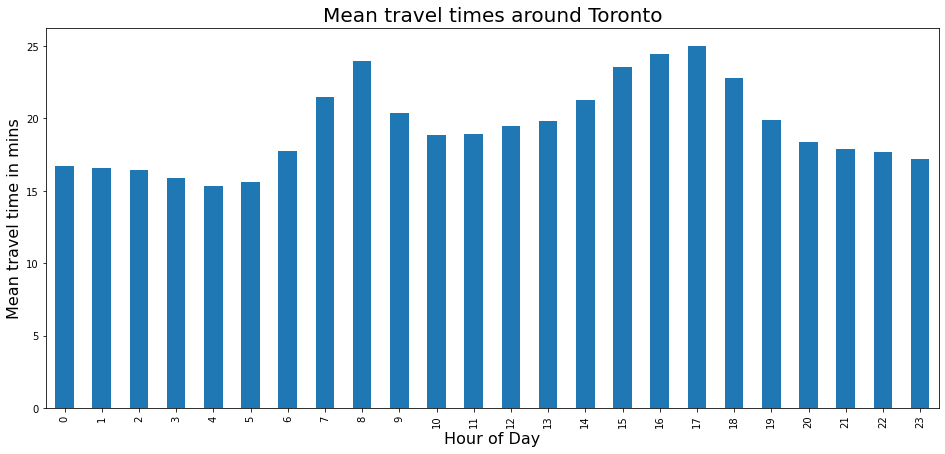

In [ ]:
mean_travel_time_by_hour_of_day = bnglr_wards_hourly.groupby('hod')['mean_travel_time'].mean()/60
plt = mean_travel_time_by_hour_of_day.plot(kind="bar", figsize=(16,7))
plt.set_title('Mean travel times around Toronto', fontsize=20)
plt.set_xlabel('Hour of Day', fontsize = 16)
plt.set_ylabel('Mean travel time in mins', fontsize = 16)

Text(0, 0.5, 'Std Dev off travel time in mins')

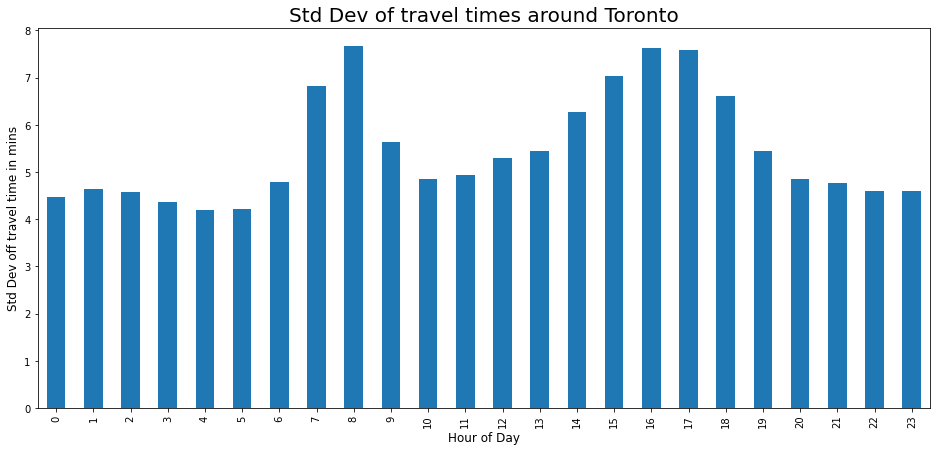

In [ ]:
std_dev_travel_time_by_hour_of_day = bnglr_wards_hourly.groupby('hod')['standard_deviation_travel_time'].mean()/60
plt = std_dev_travel_time_by_hour_of_day.plot(kind="bar", figsize = (16,7))
plt.set_title('Std Dev of travel times around Toronto', fontsize =20)
plt.set_xlabel('Hour of Day', fontsize = 12)
plt.set_ylabel('Std Dev off travel time in mins', fontsize = 12)

# **The Json Data (Map)**

In [ ]:
bglr = gpd.read_file('/content/drive/MyDrive/DF ETA/toronto_neighbourhoods.json')

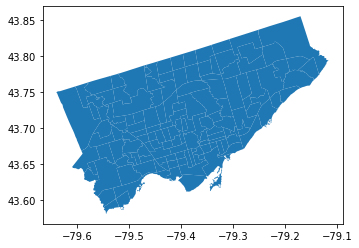

In [ ]:
bglr.plot()

In [ ]:
bglr.head()

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"York University Busway, York University Height...","MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto","MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ..."
2,3,"3400 Kingston Road, Scarborough Village, Scarb...","MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto","MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ..."
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...","MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ..."


# **Picking centroids to represent an area**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


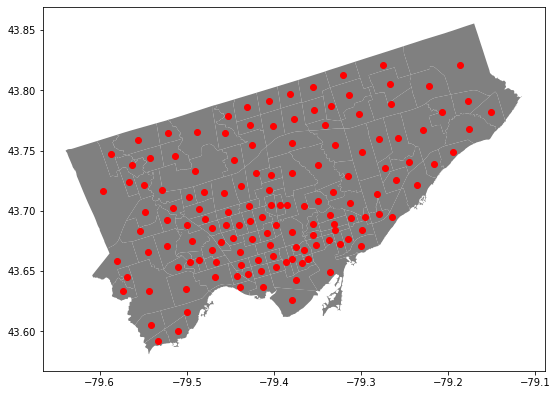

In [ ]:
bglr_c = bglr.copy()
bglr_c.geometry = bglr_c['geometry'].centroid
fig, ax = plot.subplots(figsize=(9,9))
bglr.plot(color='grey',ax=ax)
bglr_c.plot(color='red',ax=ax)

In [ ]:
id_to_dest = travel_times[['Destination Movement ID', 'Destination Display Name']]
id_to_dest.columns = ['id', 'name']
id_to_dest.head()

,id,name
0,1,"York University Busway, York University Height..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto"
2,3,"3400 Kingston Road, Scarborough Village, Scarb..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto"
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor..."


# **Get some random points from each ward to diversify representation**

In [ ]:
from shapely.geometry import Point
import random

# The number of rows with random points to be created corresponding to each row in source df
number = 3

def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points

def diversify_geo_data(df):
    new_df = gpd.GeoDataFrame()
    common_columns = df.columns
    common_columns.tolist().remove('geometry')
    for row in df.itertuples():
        points = random_points_in_polygon(number, row.geometry)
        for point in points:
            tmp = gpd.GeoDataFrame(columns=df.columns, data=[list(row[1:3]) + [point]])
            new_df = new_df.append(tmp, ignore_index=True)
    return new_df
            

diversified_points = diversify_geo_data(bglr)
diversified_points.sample(5)

,MOVEMENT_ID,DISPLAY_NAME,geometry
300,101,"1900 Lawrence Avenue East, Wexford, Scarboroug...",POINT (-79.28839 43.74877)
92,31,"100 Wareside Road, Etobicoke West Mall, Etobic...",POINT (-79.56642 43.65042)
274,92,"300 Connaught Avenue, Newtonbrook, North York,...",POINT (-79.42707 43.79618)
205,69,"100 Torbrick Road, East Danforth, Old Toronto,...",POINT (-79.32716 43.66303)
12,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...",POINT (-79.35625 43.64184)


In [ ]:
diversified_points.shape

(423, 3)

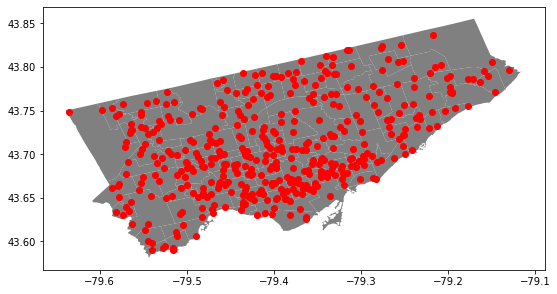

In [ ]:
fig, ax = plot.subplots(figsize=(9,9))
bglr.plot(color='grey',ax=ax)
diversified_points.plot(color='red',ax=ax)

# **Cleaning up data for analysis**
Got source and destination data and removed unneeded columns like geometric_mean_travel_time and geometric_standard_deviation_travel_time.

In [ ]:
time_df = pd.merge(bnglr_wards_hourly, id_to_dest, left_on=['sourceid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'])
time_df = time_df.rename(columns={'name': 'Source Name'})
time_df = pd.merge(time_df, id_to_dest, left_on=['dstid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id'])
time_df = time_df.rename(columns={'name': 'Destination Name'})
time_df = time_df.sort_values(by=['sourceid', 'dstid', 'hod'])
time_df.tail(5)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name
279984,141,140,20,1518.76,284.21,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279974,141,140,21,1528.77,300.13,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279980,141,140,22,1481.58,303.79,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279972,141,140,23,1431.77,301.57,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
369895,141,141,23,297.76,229.63,"Water's Edge Promenade, Downtown, Old Toronto,...","Water's Edge Promenade, Downtown, Old Toronto,..."


In [ ]:
time_df.shape

(395886, 7)

In [ ]:
bglr_c.shape

(141, 3)

In [ ]:
diversified_points.shape

(423, 3)

In [ ]:
full_bglr = bglr_c.append(diversified_points, ignore_index=True)
full_bglr.shape

(564, 3)

In [ ]:
full_bglr.head()

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"York University Busway, York University Height...",POINT (-79.48888 43.76574)
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto",POINT (-79.29960 43.67105)
2,3,"3400 Kingston Road, Scarborough Village, Scarb...",POINT (-79.21681 43.73865)
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto",POINT (-79.43934 43.63670)
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...",POINT (-79.33565 43.64929)


In [ ]:
time_df2 = pd.merge(time_df, full_bglr, left_on=['Source Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Source Ward Name', 'geometry': 'Source Geometry'})
time_df2.shape

(1583544, 9)

In [ ]:
time_df2 = pd.merge(time_df2, full_bglr, left_on=['Destination Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Destination Ward Name', 'geometry': 'Destination Geometry'})
time_df2.sample(3)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name,MOVEMENT_ID_x,Source Geometry,MOVEMENT_ID_y,Destination Geometry
1415564,76,35,2,282.49,154.97,"0 Evelyn Avenue, High Park North, Old Toronto,...","100 Rockwell Avenue, Earlscourt, Old Toronto, ...",76,POINT (-79.47634 43.65138),35,POINT (-79.46024 43.67396)
5596908,130,128,11,1151.84,253.19,"400 Lawrence Avenue East, Scarborough, Toronto","200 Queen Street East, Downtown, Old Toronto, ...",130,POINT (-79.39188 43.73683),128,POINT (-79.36730 43.65652)
3998306,49,94,15,1363.17,431.14,"300 Bay Mills Boulevard, Tam O'Shanter, Scarbo...","400 Todd Baylis Boulevard, Beechborough - Gree...",49,POINT (-79.30292 43.78013),94,POINT (-79.46764 43.69509)


In [ ]:
time_df2.shape

(6334176, 11)

In [ ]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

import os.path
def file_exists(filename):
    return os.path.exists(filename)

output_path = '/content/drive/MyDrive/DF ETA/'

In [ ]:
import geopy.distance

def calc_distance(x):
    src_point = (x['Source Geometry'].y, x['Source Geometry'].x)
    dest_point = (x['Destination Geometry'].y, x['Destination Geometry'].x)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

filename = 'Df_for_modelling.bin'
path = output_path + filename

if file_exists(path):
    # skip to next section since the results here are already precalculated
    pass
else:
    print('Creating distance file')
    time_df2['Geodesic Distance'] = time_df2.apply(func = calc_distance, axis=1)
    df = time_df2

In [ ]:
filename = 'Df_for_modelling.bin'
path = output_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        final_df = pickle.load(file)
else:
    print('Creating final df file')
    final_df = df.copy()
    final_df['Source lat'] = final_df['Source Geometry'].apply(lambda pt: float(pt.y))
    final_df['Source long'] = final_df['Source Geometry'].apply(lambda pt: float(pt.x))
    final_df['Dest lat'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.y))
    final_df['Dest long'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.x))

    
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']
final_df = final_df[features + outcome]

try:
    save_object(final_df, path)
except:
    pass
  

In [ ]:
final_df.shape

(6334176, 7)

# **Modeling**

In [ ]:
#split train and test
X = final_df[features]
y = final_df[outcome]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

## XGBoost

We used XGBoost to model the ETA. We observed R-squared, MSE, RMSE, and MAE values by tuning the number of estimators. Number of estimators = 500 turned out to be the best model from the perspective of those metrics.

In [ ]:
#xgb model
import xgboost as xgb

filename = 'XGB_model_est500.bin'
path = output_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        my_model = pickle.load(file)
else:
    my_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=4, objective='reg:squarederror')
    my_model.fit(X_train, y_train,verbose=False)
    
try:    
    save_object(X_train, output_path + 'train_set_x.bin')
    save_object(y_train, output_path + 'train_set_y.bin')
    save_object(X_test, output_path + 'test_set_x.bin')
    save_object(y_test, output_path + 'test_set_y.bin')
    save_object(my_model, output_path + filename)
except:
    pass

[11:19:19] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


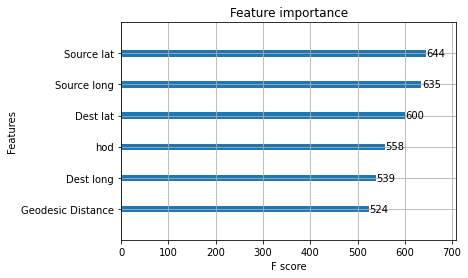

In [ ]:
xgb.plot_importance(my_model)

XGB with number of estimators = 500 shows that the coordinate of source point plays the highest role in ETA. However, this does not applies in every experiment (i. e. varying the number of estimators).

Feature importance of each experiment:
1. n estimators = 50, geodesic distance
2. n estimators = 200, geodesic distance with hours of day comes very close in the second place
3. n estimators = 350, source latitude with hours of day and source longitude score very close to the most important feature

In [ ]:
#model evaluation
predictions = my_model.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.8149401721289706

MSE: 52883.74292262073

RMSE: 229.9646558117589

MAE: 177.87620889492192



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


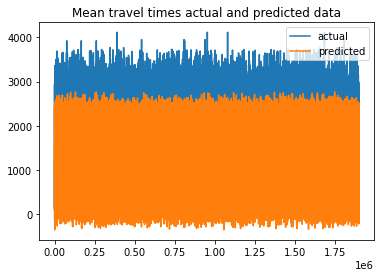

In [ ]:
#plot predict and actual
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="actual")
plot.plot(x_ax, predictions, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

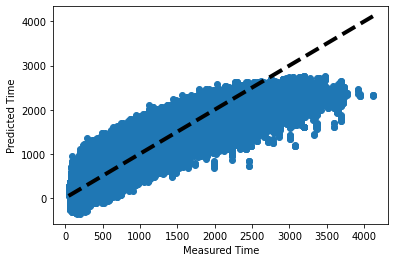

In [ ]:
fig, ax = plot.subplots()
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

The two visualizations above show the performance of the model compared to measured times in validation test. Below is the comparison of evaluation metrics between eaxh experiment.

([<matplotlib.axis.XTick at 0x7fda9bf96150>,
 [Text(0, 0, '50'),
  Text(0, 0, '100'),
  Text(0, 0, '200'),
  Text(0, 0, '350'),
  Text(0, 0, '500')])

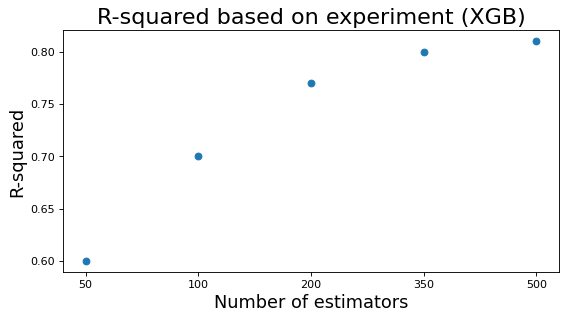

In [ ]:
X = ['50', '100', '200', '350', '500']
X_axis = np.arange(len(X))
r2 = [0.60, 0.70, 0.77, 0.80, 0.81]
mse = [112836, 83509, 66331, 57562, 52883]
rmse = [335.9, 288.9, 257.5, 239.9, 229.9]
mae = [253.3, 220.36, 197.8, 185.3, 177.87]

figure(figsize=(8, 4), dpi=80)
plt.scatter(X_axis, r2)

plt.title('R-squared based on experiment (XGB)', fontsize=20)
plt.xlabel('Number of estimators', fontsize = 16)
plt.ylabel('R-squared', fontsize = 16)
plt.xticks(X_axis, X)

([<matplotlib.axis.XTick at 0x7fda9ba9dbd0>,
 [Text(0, 0, '50'),
  Text(0, 0, '100'),
  Text(0, 0, '200'),
  Text(0, 0, '350'),
  Text(0, 0, '500')])

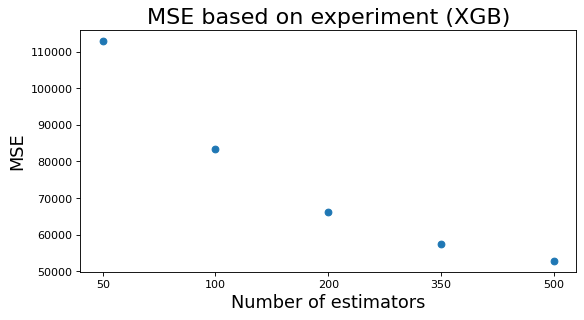

In [ ]:
figure(figsize=(8, 4), dpi=80)
plt.scatter(X_axis, mse)

plt.title('MSE based on experiment (XGB)', fontsize=20)
plt.xlabel('Number of estimators', fontsize = 16)
plt.ylabel('MSE', fontsize = 16)
plt.xticks(X_axis, X)

([<matplotlib.axis.XTick at 0x7fda9b9d3590>,
 [Text(0, 0, '50'),
  Text(0, 0, '100'),
  Text(0, 0, '200'),
  Text(0, 0, '350'),
  Text(0, 0, '500')])

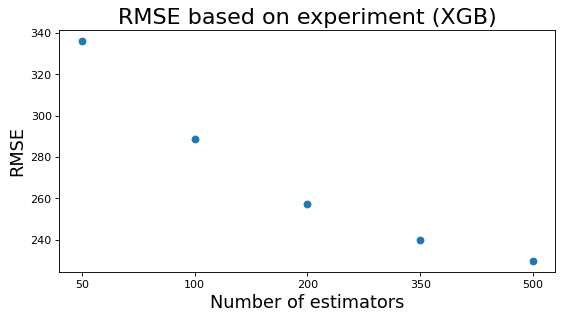

In [ ]:
figure(figsize=(8, 4), dpi=80)
plt.scatter(X_axis, rmse)

plt.title('RMSE based on experiment (XGB)', fontsize=20)
plt.xlabel('Number of estimators', fontsize = 16)
plt.ylabel('RMSE', fontsize = 16)
plt.xticks(X_axis, X)

([<matplotlib.axis.XTick at 0x7fda9b9a5610>,
 [Text(0, 0, '50'),
  Text(0, 0, '100'),
  Text(0, 0, '200'),
  Text(0, 0, '350'),
  Text(0, 0, '500')])

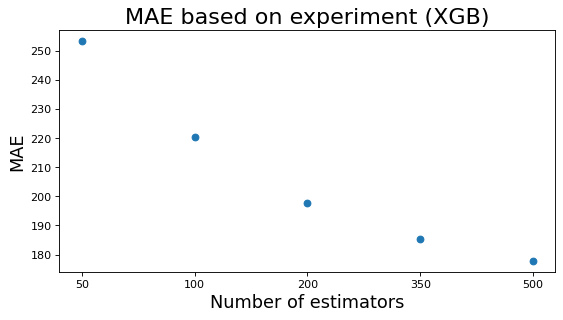

In [ ]:
figure(figsize=(8, 4), dpi=80)
plt.scatter(X_axis, mae)

plt.title('MAE based on experiment (XGB)', fontsize=20)
plt.xlabel('Number of estimators', fontsize = 16)
plt.ylabel('MAE', fontsize = 16)
plt.xticks(X_axis, X)

## K-Nearest Neighbor

In [ ]:
#modeling
from sklearn.neighbors import KNeighborsRegressor

filename = 'KNN_model.bin'
path = output_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        my_model = pickle.load(file)
else:
  my_model = KNeighborsRegressor(n_neighbors=5)
  my_model.fit(X_train, y_train)
    
try:    
    save_object(X_train, output_path + 'train_set_x.bin')
    save_object(y_train, output_path + 'train_set_y.bin')
    save_object(X_test, output_path + 'test_set_x.bin')
    save_object(y_test, output_path + 'test_set_y.bin')
    save_object(my_model, output_path + filename)
except:
    pass

In [ ]:
#evalute model
predictions = my_model.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.8256585267839672

MSE: 49820.80528429468

RMSE: 223.20574653062738

MAE: 165.90256154838335



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


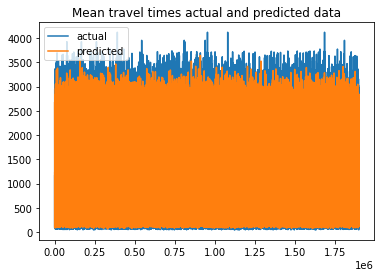

In [ ]:
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="actual")
plot.plot(x_ax, predictions, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

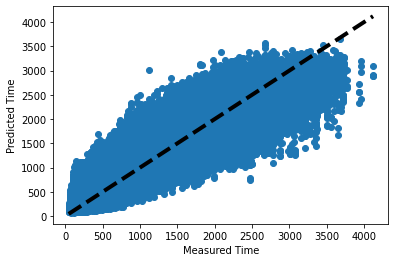

In [ ]:
fig, ax = plot.subplots()
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

## Gradient Boosting

In [ ]:
# Import GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 100,
          'max_depth': 9,
          'min_samples_split': 2,
          'learning_rate': 0.05,
          'loss': 'ls'}
gbc = GradientBoostingRegressor(**params)

# Fitting model using train data

gbc.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=9,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# Validation Model using Test Data

prediction = gbc.predict(X_test)

# Evaluations Model

from sklearn import metrics

r2 = metrics.r2_score(y_test, prediction)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, prediction)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, prediction)
print('MAE: {}\n'.format(mae))

R2: 0.8871388151664762

MSE: 32251.850406118367

RMSE: 179.5880018434371

MAE: 136.80585151772607



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


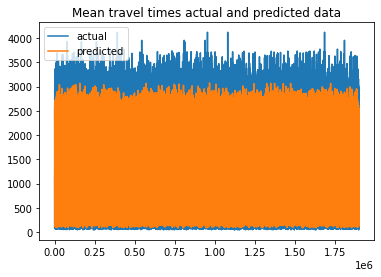

In [ ]:
# Plotting data into graph to compare actual data with predicted data

x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="actual")
plot.plot(x_ax, prediction, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

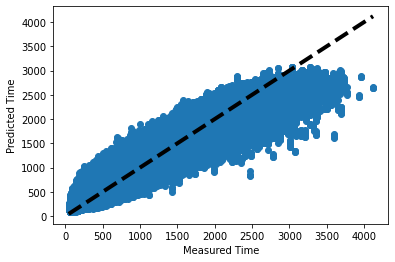

In [ ]:
fig, ax = plot.subplots()
ax.scatter(y_test, prediction)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

## Random Forest

In [ ]:
# Modelling with depth 20
from sklearn.ensemble import RandomForestRegressor
filename = 'randomforestreg_2.bin'
path = output_path + filename

# Check if model exists in folder
if file_exists(path):
    with open(path, 'rb') as file:
        regr = pickle.load(file)
else:
    # Fit model to training data
    regr = RandomForestRegressor(max_depth=20, min_samples_leaf=5, random_state=5)
    regr.fit(X_train, np.ravel(y_train))

try:    
  save_object(regr, path)
except:
    pass

In [ ]:
# Predict model using testing data
reg_pred = regr.predict(X_test)

# Evaluate model using R2, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Error
from sklearn import metrics
r2 = metrics.r2_score(y_test, reg_pred)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, reg_pred)
print('MSE: {}\n'.format(mse))
print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, reg_pred)
print('MAE: {}\n'.format(mae))

R2: 0.9846128171730204

MSE: 4397.128378896229

RMSE: 66.31084661574025

MAE: 38.49412887857128



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


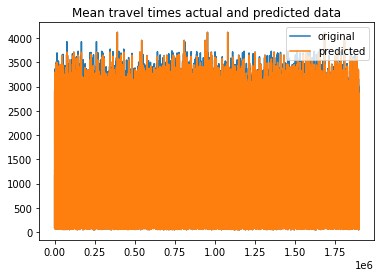

In [ ]:
# Plot original time and predicted time comparison
x_ax = range(len(y_test))

plot.plot(x_ax, y_test, label="original")
plot.plot(x_ax, reg_pred, label="predicted")
plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

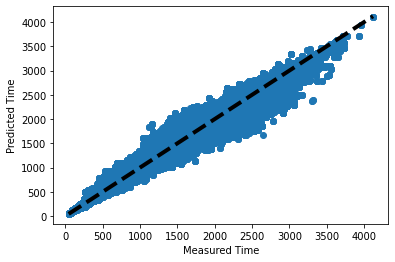

In [ ]:
fig, ax = plot.subplots()
ax.scatter(y_test, reg_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

# **Live Testing**


Suppose a person wants to travel from York University to Ontario Science Centre.

York University = [43.77340238964325, -79.5018178899002]

Ontario Science Centre = [43.717303195452715, -79.33914640029785]

From google map the ETA is 33 minutes by car

In [ ]:
def get_distance(lat1, long1, lat2, long2):
    src_point = (lat1, long1)
    dest_point = (lat2, long2)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

def prepare_df(lat1, long1, lat2, long2, hod):
    distance = get_distance(lat1, long1, lat2, long2)
    return pd.DataFrame(columns = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance'],
                 data = [[lat1, long1, lat2, long2, hod, distance]])
    
def predict(df):
    return my_model.predict(df[features])

## **XGBoost**

Using XGBoost (n estimator = 500), the ETA is 27.8 minutes.

In [ ]:
src_point_tes = [43.77340238964325, -79.5018178899002]
dest_point_tes = [43.717303195452715, -79.33914640029785]
lat1, long1 = src_point_tes[0], src_point_tes[1]
lat2, long2 = dest_point_tes[0], dest_point_tes[1]
hod = 8

df = prepare_df(lat1, long1, lat2, long2, hod)
predict(df)

array([1669.7095], dtype=float32)

In [ ]:
1669.7095/60

27.828491666666665

## **K-Nearest Neighbor**

Using KNN, the ETA is 29.2 minutes.

In [ ]:
src_point_tes = [43.77340238964325, -79.5018178899002]
dest_point_tes = [43.717303195452715, -79.33914640029785]
lat1, long1 = src_point_tes[0], src_point_tes[1]
lat2, long2 = dest_point_tes[0], dest_point_tes[1]
hod = 8

df = prepare_df(lat1, long1, lat2, long2, hod)
predict(df)

array([[1752.784]])

In [ ]:
1752.784/60

29.21306666666667

## **Gradient Boosting**

Using Gradient Boosting, the ETA is 27.14 minutes.

In [ ]:
src_point_tes = [43.77340238964325, -79.5018178899002]
dest_point_tes = [43.717303195452715, -79.33914640029785]
lat1, long1 = src_point_tes[0], src_point_tes[1]
lat2, long2 = dest_point_tes[0], dest_point_tes[1]
hod = 8

df = prepare_df(lat1, long1, lat2, long2, hod)
predict(df)

array([1628.89527206])

In [ ]:
1628.89527206/60

27.148254534333333

## **Random Forest**

Using Random Forest, the ETA is 24.76 minutes.

In [ ]:
# Get random points and set as source and destination
# Let's travel from York University to Ontario Science Centre

src_point_tes = [43.77340238964325, -79.5018178899002]
dest_point_tes = [43.717303195452715, -79.33914640029785]
lat1, long1 = src_point_tes[0], src_point_tes[1]
lat2, long2 = dest_point_tes[0], dest_point_tes[1]
hod = 10

df = prepare_df(lat1, long1, lat2, long2, hod)
predict(df)

array([1485.6494], dtype=float32)

In [ ]:
1485.6494/60

24.760823333333335

# **Which one is the best model?**

We based our decision on the evaluation metric to choose the best model. Below visualization shows the performance of each algorithm.

([<matplotlib.axis.XTick at 0x7fda9b91b490>,
 [Text(0, 0, 'XGB'),
  Text(0, 0, 'KNN'),
  Text(0, 0, 'Gradient Boosting'),
  Text(0, 0, 'Random Forest')])

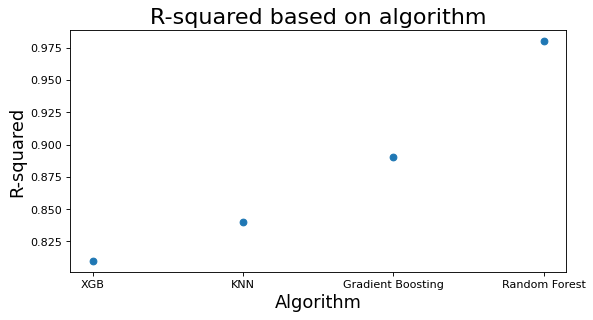

In [ ]:
X = ['XGB', 'KNN', 'Gradient Boosting', 'Random Forest']
X_axis = np.arange(len(X))
r2_ = [0.81, 0.84, 0.89, 0.98]


figure(figsize=(8, 4), dpi=80)
plt.scatter(X_axis, r2_)

plt.title('R-squared based on algorithm', fontsize=20)
plt.xlabel('Algorithm', fontsize = 16)
plt.ylabel('R-squared', fontsize = 16)
plt.xticks(X_axis, X)